In [1]:
import missing_data_code as mdc
import exploration_pca_ca as epc
import normalization as norm
import weights as wts
import jellyfish
#import importlib
#importlib.reload(mdc)
#importlib.reload(epc)
#importlib.reload(norm)
#importlib.reload(wts)

# A Guide for Building a Composite Index

This guide seeks to explain several steps critical to building a statistically sounds composite index. In particular, the guide will focus on rationale, theory, and examples for imputing missing variables, undertaking multivariable analysis, normalizing data, weighting variables, and aggregating variables to get to a final composite index. 

Given that InSight Crime has yet to collect the relevant data for their index, this guide will use a self-compiled [dataset](https://github.com/marioamz/MexicoOC_Index/blob/master/data/Mexico_Final.xlsx) that brings together education, crime, highway, geographic, and metal production data for each of the 32 Mexican states as an attempt to build an index on organized crime presence in each Mexican state. It should be noted that, given how quickly this data was compiled, these variables are likely not to result in an accurate index. We only use this data as a way to show, step-by-step, how to build the composite index.

Lastly, all the code that produced the graphs and results below is housed in this [github](https://github.com/marioamz/MexicoOC_Index) and can be seen as a skeleton framework that needs to be further developed for deployment by InSight Crime.

## The Ten Steps to Building a Composite Index 

Several multi-lateral organizations, including the United Nations and the European Union, have identified ten steps that constitute a statistically sound composite index. These are:

- **Establishing a theoretical framework** - This step entails understanding if the variables we have chosen, when combined, can realistically result in a sound composite number. It requires a review of the literature pertaining to the subject area. 

- **Selecting data** - This step entails searching for and selecting the data that will feed the composite index. In taking this step, it's critical that the index builder takes care to find complete datasets or, in the case of scarce data, finds proxy variables that can estimate what he or she cares to measure.

- **Imputating missing data** - Once the data is collected, it's likely that some variables will have missing entries. In most cases, it's considered best practice to deploy statistical methods to estimate the values of those missing cases.

- **Multivariate analysis and data exploration** - Prior to building the composite index, it's critical that the builder explore the collected data in order to ascertain it's structure, distribution, and correlations. If the data is not behaving as expected in this exploratory phase, it might be necessary to return to the data selection step.

- **Normalization** - Since indices often aggregate variables that do not share units of measurement, it's critical that all variables that feed into the composite index be normalized to share the same units -- they cannot be aggregated otherwise.

- **Weighting and aggregating** - Certain variables are likely to have more of an effect on the social phenomenom we seek to measure than others, which is why it's important that we weigh the impact of those variables more than others. Similarly, statistical techniques are needed to aggregate the weighted variables that account for the nature of the relationship among variables. This step gets you the final, composite index number.

- **Robustness** - It's important that the composite index methodology be rigorously tested with different data in order to make sure that the results hold no matter the inputs. This is, in effect, a check to make sure that our methods work across years and don't just select correctly for the year in question.

- **Back to the real data** - The composite index is tested to make sure it can be deconstructed back to the original data -- this is, in effect, a test to make the methods used to build it are accurate and replicable.

- **Links to other variables** - It's important that the composite index be checked against comparable indices in order to determine it's robustness. If it finds results that differ significantly from other measures, it likely implies issues in the collection or processing of data.

- **Presentation and visualization** - This step entails the presentation and communication of the results of the index. 

Currently, InSight Crime is completing the first two steps of building a composite index -- establishing a theoretical framework through it's data collecting protocols and selecting data. Therefore, this guide will not cover those two steps other than to warn that the current data collection methods employed by InSight Crime, which entail collecting data from different sources for each variable, raises serious methodological questions. At the very least, InSight Crime should be fully transparent in their data collection methods and issues inherent in them, when it's time to publish the composite index.

Instead, this guide will cover steps 3-6: imputing missing data, multivariate analysis and data exploration, normalization, and weigthing and aggregating. The final four steps will not be addressed here due to the condensed timeline for this project.

## The Example Data

As stated above, this guide will use a self-compiled dataset that brings together about 35 variables that could potentially be related to the presence of organized crime in a given Mexican state. These variables are grouped roughly around the following overarching themes (which somewhat mirror those that InSight Crime has identified):
- Work-related conflicts, which include several measures of strikes and violence related to them in each Mexican state.
- Self-reported crime, which includes citizen reported events that capture health-related crimes, violent crimes, and many other types of crimes.
- The extent and quality of the highway system in a given state, as a measure of ease of transport for all types of goods.
- Metal production per year, which can speak to the increasing influence that organized crime groups exert over that illicit economy.
- Length of coast, which indicates how important of a port of entry or exit a certain state might be. 

As noted, these variables were selected quickly and based on publicly available Mexican government data. They're likely not to result in a sound index since they don't capture the complexity of criminal organizations or the breadth of their involvement in different illicit economies. This data, however, is a perfect example case for this guide, whose sole purpose in walking the reader through building an index.

Currently, the data collected is from 2010-2016. For simplicity's sake, we will only attempt to build the index for 2012 in this guide. 2012 was chosen randomly. This is what the first five rows of this data looks like:

In [2]:
df = mdc.reading_in('data/Mexico_Final.xlsx')
# per 100,000 calculation
df.iloc[:,2:24] = (df.iloc[:,2:24].div(df.iloc[:,-1], axis=0)) *100000
del df['pop']
replacing = {'Aguascalientes':1, 'Baja California':2, 'Baja California Sur':3, 'Campeche':4, 'Coahuila de Zaragoza':5, 'Colima':6, 'Chiapas':7, 'Chihuahua':8, 'Ciudad de México /b':9, 'Durango':10, 'Guanajuato':11, 'Guerrero':12, 'Hidalgo':13, 'Jalisco':14, 'México':15, 'Michoacán de Ocampo':16, 'Morelos':17, 'Nayarit':18, 'Nuevo León':19, 'Oaxaca':20, 'Puebla':21, 'Querétaro':22, 'Quintana Roo':23, 'San Luis Potosí':24, 'Sinaloa':25, 'Sonora':26, 'Tabasco':27, 'Tamaulipas':28, 'Tlaxcala':29, 'Veracruz de Ignaxio de la Llave':30, 'Yucatán':31, 'Zacatecas':32}

new_col = []
for c in df['entidad']:
    for state, rep in replacing.items():
        if jellyfish.jaro_distance(c.strip(), state) > 0.95:
            new_col.append(state)

import pandas as pd
df['entidad'] = pd.Series(new_col)
df.drop(columns=['alumnos_inscritos_hs', 'hombres_inscritos_hs', 'mujeres_inscritas_hs', 'maestros_hs', 'escuelas_hs', 'municipios'], axis=1, inplace=True)

no_index = df[df['year']==2012].reset_index(drop=True)
no_index.head()

,entidad,year,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,emplazamientos_huelga_solucionados,huelgas_estalladas,huelgas_locales_solucionadas,denuncias_total,denuncias_salud,...,prod_plomo_t,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km
0,Aguascalientes,2012,276.517116,202.768413,8.509466,3.322744,0.000000,0.000000,78.692298,27.068205,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,1870,NaN
1,Baja California,2012,52.364011,304.600522,121.131207,58.702971,0.961359,0.450637,360.749884,212.610504,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,3,1493.0
2,Baja California Sur,2012,345.696339,217.713918,26.027886,5.895819,0.143800,0.000000,167.527552,98.503325,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,10,2131.0
3,Campeche,2012,513.518973,156.745058,22.161304,1.385082,0.000000,0.000000,71.331698,6.925408,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,10,425.0
4,Coahuila de Zaragoza,2012,893.308211,290.050148,14.434190,4.169099,0.000000,0.000000,78.407082,16.010740,...,0.0,0.0,0.0,1727652.0,2859829.0,0.0,25148.0,86679.0,1700,NaN


## Step 3: Imputing Missing Variables

### The Rationale 

Typically, compiled data contains missing values for a number of different reasons. In building an index, it's important to think critically about handling these instances of missing values. If the missing values are not handled properly, this could result in the final analysis drawing inaccurate inferences and obtaining different results from someone who has properly handled instances of missing information.

Prior to estimating these missing values, it's important to determine how the data is missing. Data can either be:
- Missing Completely at Random - the values that are missing have nothing to do with the entity being studies. For example, in our analysis, a missing variable for denuncias_total is due to a totally random reason and not to any characteristics of the state which would help explain our dependent variables (presence of organized crime) or any independent variables.
- Missing at Random - the values that are missing are related to an independent variable, but to the dependent variable (presence of organized crime). For example, let's suppose a state has a missing variable for kilometers of highway, but has values of zero for all the metal production variables. Given the relationship between industry presence and transportation infrastructure, one could assume that the reason for the missing value is likely due to a lack of industry in the region.
- Not Missing at Random - the values that are missing are related to the dependent variable. This is a problematic situation in which it's likely that any estimation of missing variables would, in effect, be an estimation of the variable we're trying to measure. For example, let's say a state had a missing variable for denuncias total because the state did not publish those numbers due to coercion from organized crime groups. In this case, any estimation of the missing value would be difficult and perhaps inappropriate.

### The Methods 

There are a number of different methods for estimating missing values using simple statistical techniques. These include:
- Case deletion -- rows or columns containing any missing values are deleted entirely. Typically, this method is acceptable to use when no more than 5% of your data is missing. If more than that is missing, then the analysis loses some of its power.
- Zero imputation -- missing values are estimated with zeroes. This determination is made after an analysis of the missing variables. 
- Mean imputation -- missing values are estimated with the mean value of the column. This method works best when there are no outliers to skew estimations, and when you can reasonably expect that your entities are similar.
- Mode imputation -- missing values are estimated with the mode of the column. This analysis controls for outlier effects, but again assumes some level of uniformity among entities.
- Median imputation -- missing values are estimated with the median value for the column. This analysis controls for outlier effects.
- Linear regression imputation -- missing values are estimated by training a linear regression equation for rows in which you do have full information, with the column with missing values elsehwhere as the dependent variable and all others as the independent variables. You then applied your trained linear regression equation to the row with missing values and the output becomes the estimation.
- K-Nearest Neighbors imputation -- missing values are estimated using a machine learning algorithm that finds an estimate by comparing the row with missing values to rows that are 'similar' to it based on different distance metrics.

These are a few of the options for imputing missing variables. Before choosing one, it's important to understand how your variables are missing and which would make the most sense.

### Imputing Missing Variables in our Dataset

The first step in determining which method to deploy in estimating missing values is to understand which values are missing, and develop a theory as to how they're missing: completely at random, at random, or not at random. Once you've developed this theory, you can deploy a method to impute.

The graph below shows us which variables are missing, and gives us a sense of any trends in missingness.

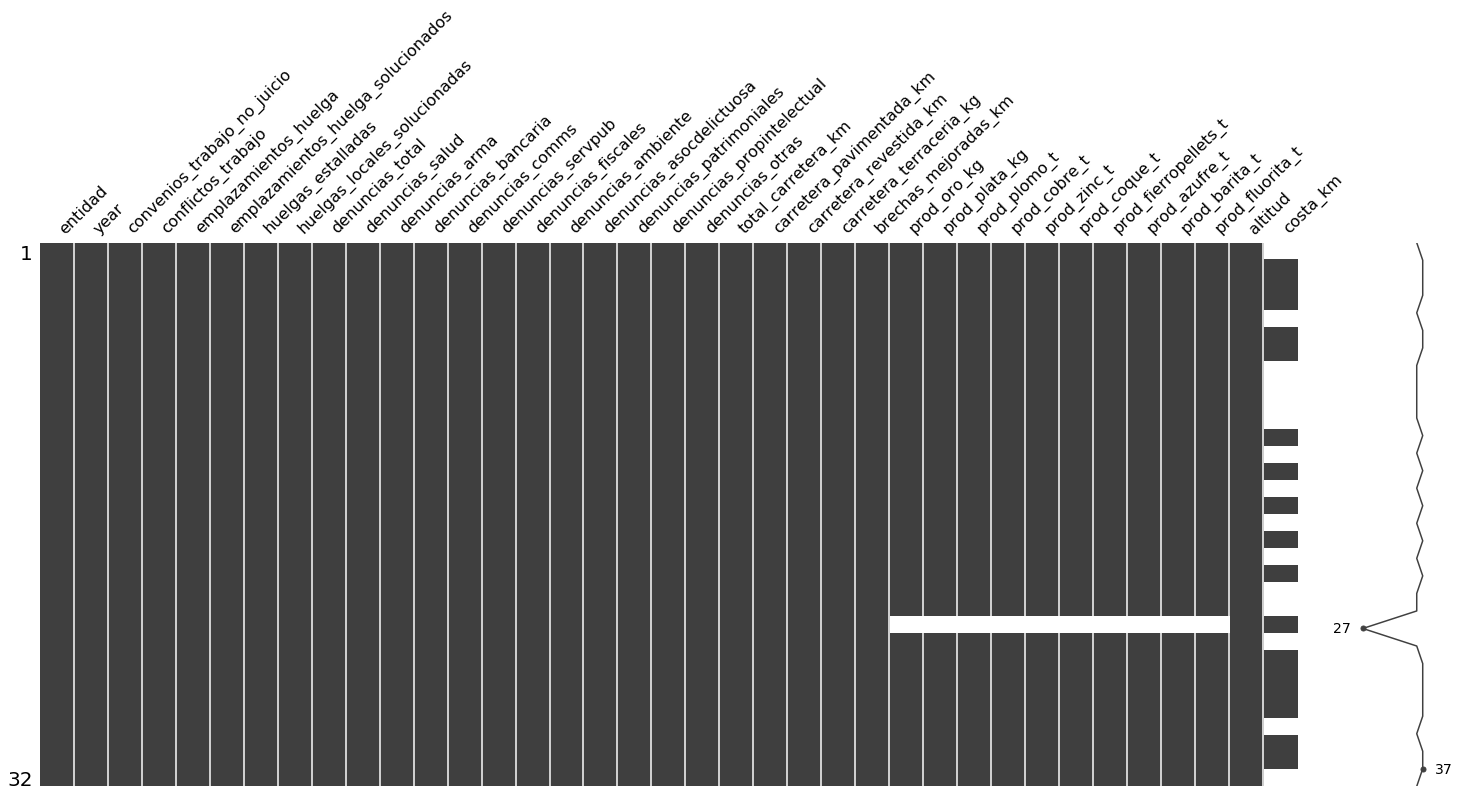

In [3]:
mdc.visualizing_nulls(no_index, 'nullity')

An analysis of the graph leads to several conclusions: a number of states have missing variables for kilometers of coastline and there appears to be on state that has missing values for all of the metal production variables. In thinking through reasons for why these variables are missing, it's striking that one is related to geography and the other to metal production (qualities that all states do not share equally). The first instinct here should be to think that these variables are missing because these are actually values that are zero, and whoever entered them skipped filling them out entirely.

Next, we'll try to figure out how many variables are missing in order to further confirm our theory that these values are missing because the values in question are actually zero

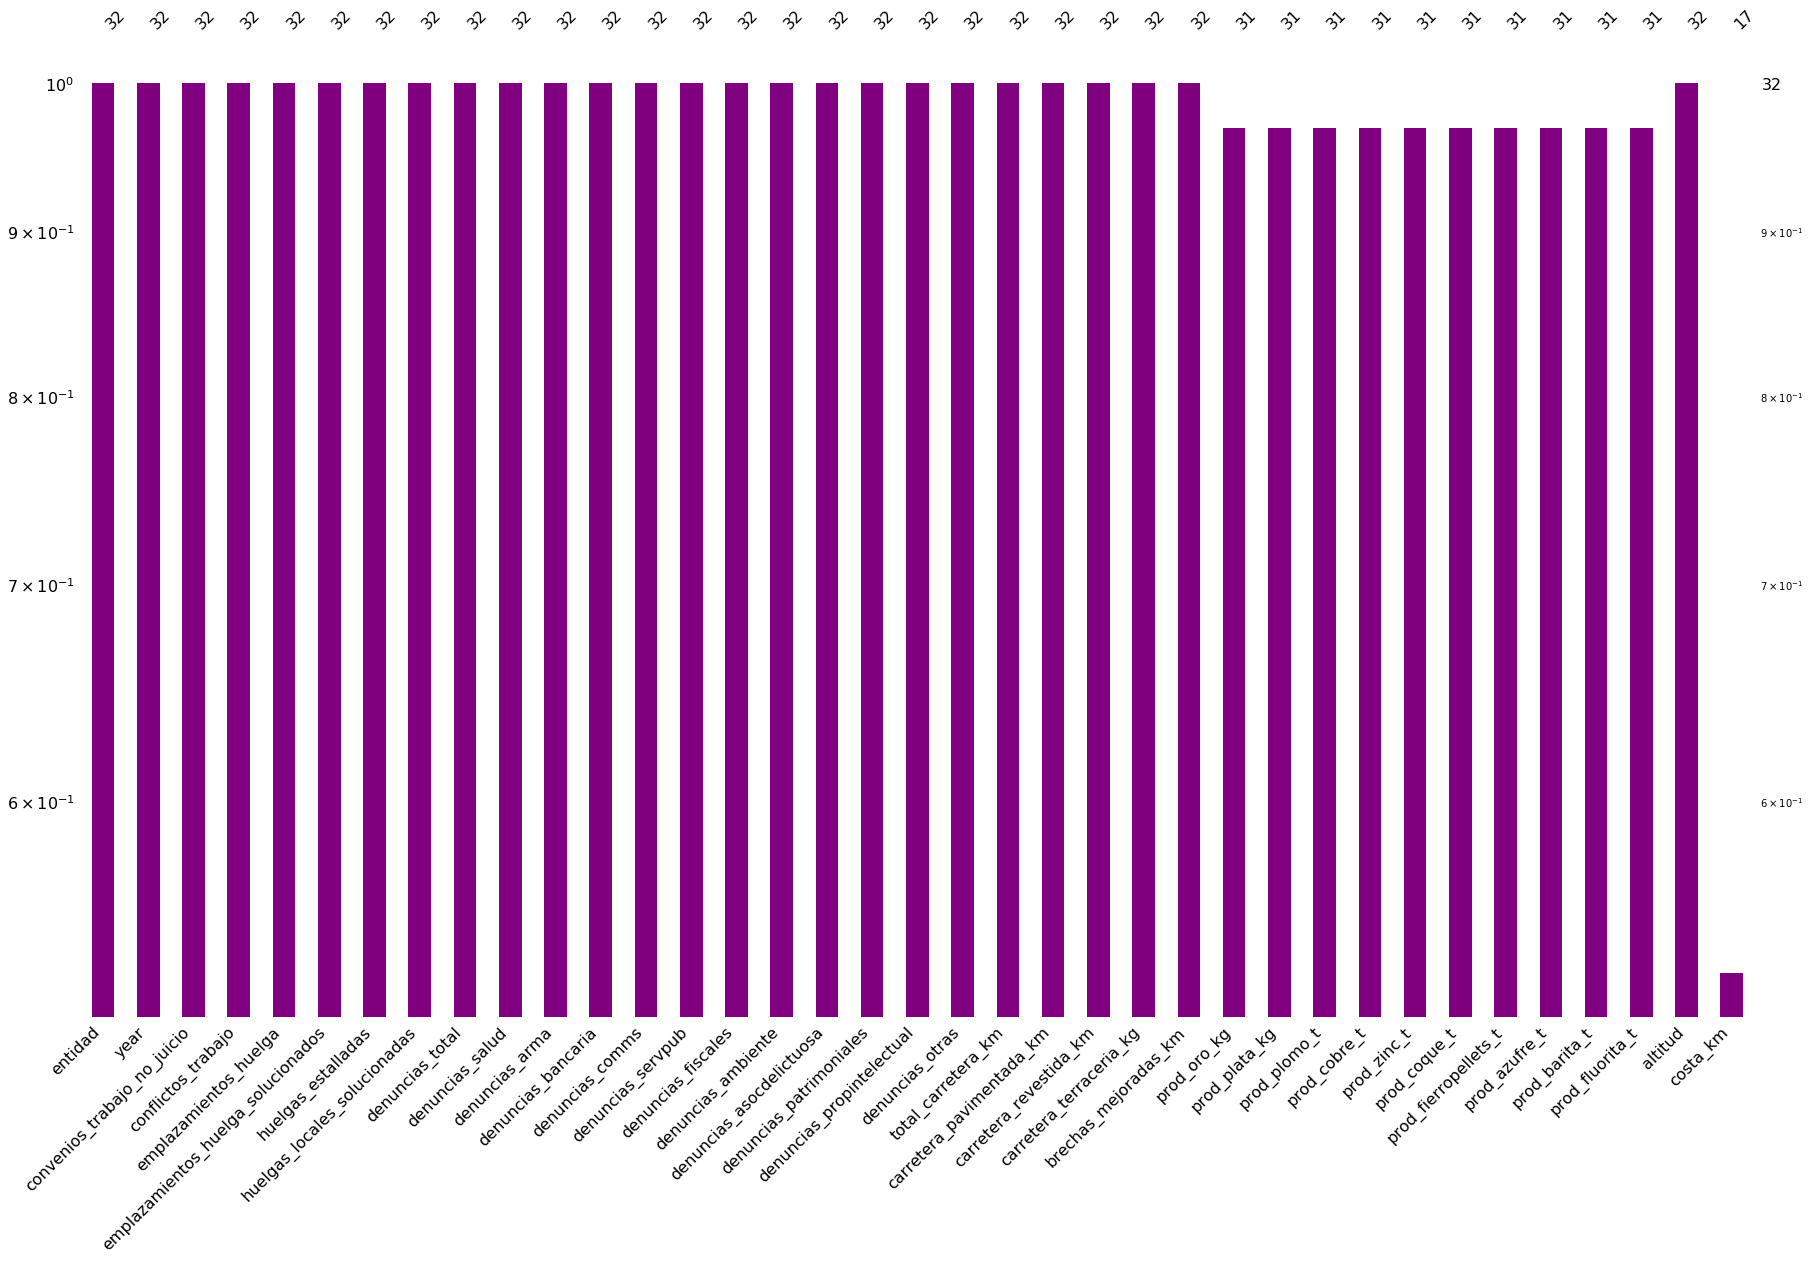

In [4]:
mdc.visualizing_nulls(no_index, 'bar')

This graph confirms two things: there is only one state across all the metal production variables that has missing values, and there are 16 states with missing values for coastline, which tracks closely with the amount of landlocked states in the country. 

In order to fully tease this out, we need to determine which states correspond to the missing values.

In [5]:
null_cols = mdc.find_missing_cols(no_index)
missing_rows = mdc.find_missing_rows(no_index, 'entidad', null_cols)
missing_rows

{('Aguascalientes', 'costa_km'),
 ('Chihuahua', 'costa_km'),
 ('Ciudad de México /b', 'costa_km'),
 ('Coahuila de Zaragoza', 'costa_km'),
 ('Durango', 'costa_km'),
 ('Guanajuato', 'costa_km'),
 ('Hidalgo', 'costa_km'),
 ('Morelos', 'costa_km'),
 ('México', 'costa_km'),
 ('Nuevo León', 'costa_km'),
 ('Puebla', 'costa_km'),
 ('Querétaro', 'costa_km'),
 ('Quintana Roo', 'prod_azufre_t'),
 ('Quintana Roo', 'prod_barita_t'),
 ('Quintana Roo', 'prod_cobre_t'),
 ('Quintana Roo', 'prod_coque_t'),
 ('Quintana Roo', 'prod_fierropellets_t'),
 ('Quintana Roo', 'prod_fluorita_t'),
 ('Quintana Roo', 'prod_oro_kg'),
 ('Quintana Roo', 'prod_plata_kg'),
 ('Quintana Roo', 'prod_plomo_t'),
 ('Quintana Roo', 'prod_zinc_t'),
 ('San Luis Potosí', 'costa_km'),
 ('Tlaxcala', 'costa_km'),
 ('Zacatecas', 'costa_km')}

As suspected, the missing values for coastline are all from landlocked states which lends credence to our theory that this data is missing completely at random and is likely missing because at entry, zeroes were turned to nulls. Similarly, Quintana Roo is missing values for every single one of the metal production variables. Given that it's not a large metal producing state, this is also likely a case of missing completely at random.

Given that our values are missing completely at random, and are likely so because they were originally zeroes, this is an easy imputation case in which we will impute all missing values with zeroes. The updated data is below.

In [6]:
zero = mdc.impute_zero(no_index, {'costa_km':0, 'prod_azufre_t':0, 'prod_barita_t':0, 'prod_cobre_t':0, 'prod_coque_t':0, 'prod_fierropellets_t':0, 'prod_fluorita_t':0, 'prod_oro_kg':0, 'prod_plata_kg':0, 'prod_plomo_t':0, 'prod_zinc_t':0})
zero.head()

,entidad,year,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,emplazamientos_huelga_solucionados,huelgas_estalladas,huelgas_locales_solucionadas,denuncias_total,denuncias_salud,...,prod_plomo_t,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km
0,Aguascalientes,2012,276.517116,202.768413,8.509466,3.322744,0.000000,0.000000,78.692298,27.068205,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,1870,0.0
1,Baja California,2012,52.364011,304.600522,121.131207,58.702971,0.961359,0.450637,360.749884,212.610504,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,3,1493.0
2,Baja California Sur,2012,345.696339,217.713918,26.027886,5.895819,0.143800,0.000000,167.527552,98.503325,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,10,2131.0
3,Campeche,2012,513.518973,156.745058,22.161304,1.385082,0.000000,0.000000,71.331698,6.925408,...,0.0,0.0,0.0,0.0,3944485.0,0.0,0.0,0.0,10,425.0
4,Coahuila de Zaragoza,2012,893.308211,290.050148,14.434190,4.169099,0.000000,0.000000,78.407082,16.010740,...,0.0,0.0,0.0,1727652.0,2859829.0,0.0,25148.0,86679.0,1700,0.0


## Step 4: Data Exploration and Multivariable Analysis 

### The Rationale 

Before constructing a composite index, it's important to have a fundamental understanding of the underlying. Primarily, it's critical to determine the disribution of the data, how different variables are correlated to each other, and if unsupervised methods are grouping variables and entities in ways that are expected. In doing so, we can ascertain that the data collection phase of the build was adequate.

### The Methods

Data exploration is an incredibly involved process that often entails a number of different charts and analysis, with the ultimate aim of teasing out any pre-existing relationships between variables or any 'secrets' the data might have. This guide won't cover the majority of these methods, rather it will focus on showing summary statistics, histograms, box plots, and correlation heatmaps.

It will also deploy mulitvariable analysis as a descriptive tool. In particular, we will employ principal component analysis to see which variables group together in dimension reduction and clustering analysis to see how states group together. By using unsupervised methods that group variables and states together without the builder's intervention, we can tease out underlying dynamics that might be present in the data and develop a hypothesis as to the suitability of our data for building this composite index. Furthermore, if the groupings are strong, the cluster analysis could feasibly serve as the final composite index score.

We will show the following methods:
- Summary statistics -- for each column, the mean, standard deviation, and percentiles are returned. It gives an introductory look at the layout of the data.
- Histograms -- for each column, it shows the distribution of the data. 
- Box Plots -- for each column, shows if there exist outliers and if they're outside a typical standard deviation.
- Correlation Heatmap -- shows the correlations between variables and if they're positive and negative.
- Principal Component Analysis -- reduces the number of columns based on how much variance can be explained by grouping variables together, and let's you see which variables are grouped.
- Cluster Analysis -- clusters the states together based on how similar they are, we'll deploy to different methods: kmeans and affinity propagation

### Exploring our Dataset

#### *Summary Statistics* 

The most basic form of data exploration is finding summary statistics (mean, percentiles, etc...) for each of the columns in question, and printing out histograms to determine the distribution of each variable. 

For the dataset in question, that analysis is below.


Summary stats for convenios_trabajo_no_juicio
count      32.000000
mean      361.668757
std       317.713520
min        20.771164
25%       113.931967
50%       343.188149
75%       496.850190
max      1565.268207
Name: convenios_trabajo_no_juicio, dtype: float64


Summary stats for conflictos_trabajo
count     32.000000
mean     188.987910
std       97.339226
min       39.678705
25%      103.363775
50%      174.512816
75%      272.281071
max      366.059843
Name: conflictos_trabajo, dtype: float64


Summary stats for emplazamientos_huelga
count     32.000000
mean      28.794459
std       30.164566
min        4.534143
25%        9.825032
50%       18.962381
75%       38.284755
max      132.721470
Name: emplazamientos_huelga, dtype: float64


Summary stats for emplazamientos_huelga_solucionados
count     32.000000
mean      14.649545
std       25.507287
min        0.000000
25%        2.727711
50%        5.621309
75%       14.506642
max      134.734268
Name: emplazamientos_huelga_soluci

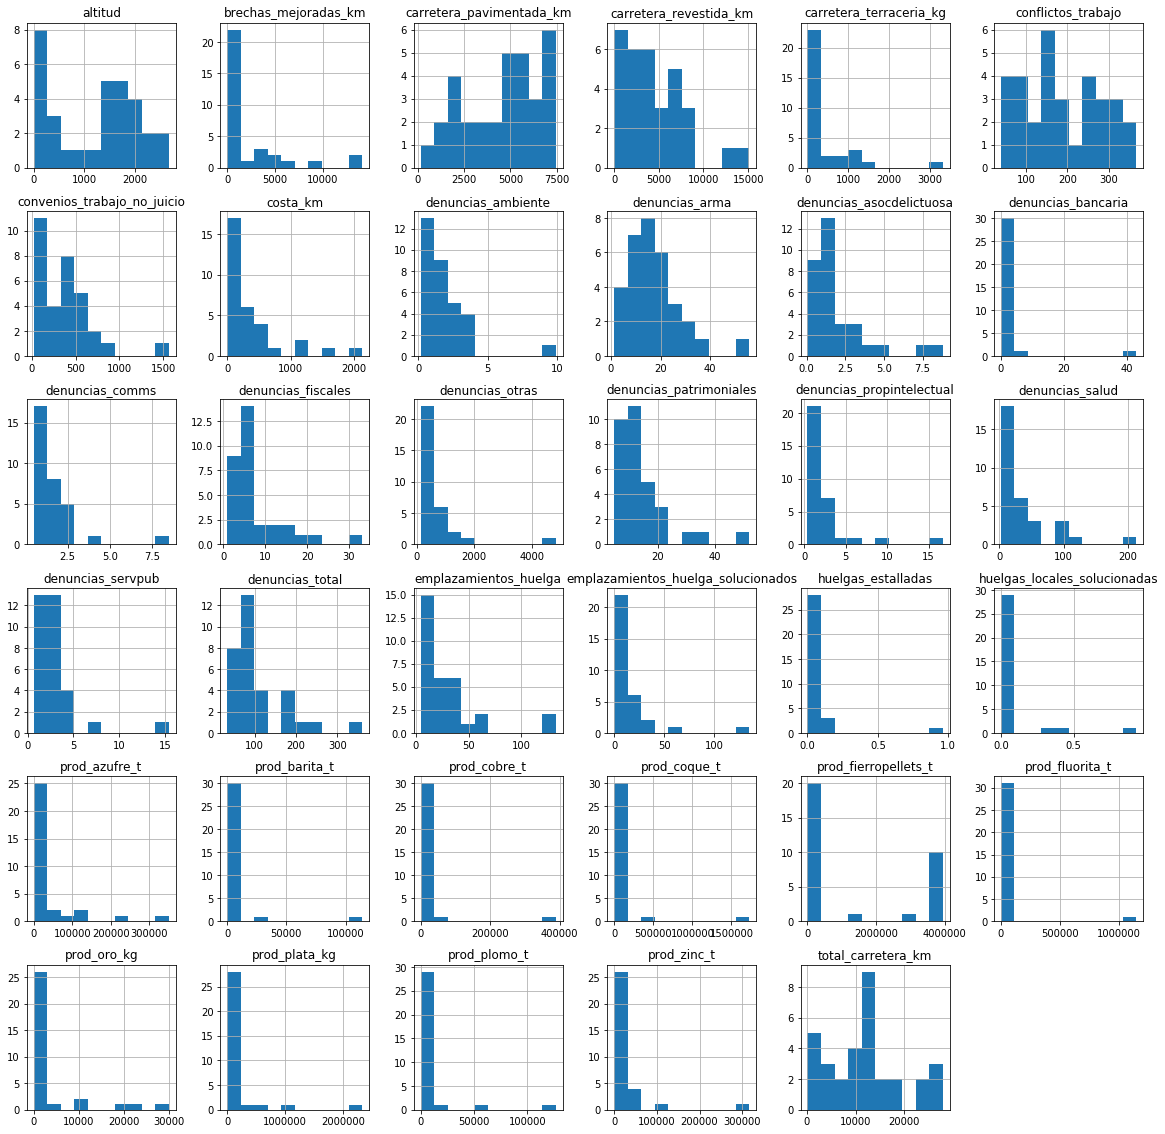

In [7]:
index = zero.set_index(['entidad', 'year'])
epc.explore_data(index)

This straightforward analysis doesn't reveal any significant issues or findings in our current dataset. There appear to be some strange distrubutions in the metal production variables, but that's likely due to some states not having any metal producing industry. 

#### *Outliers and Box Plots*

The next step in the analysis would be to determine which variables, if any, have outliers and if we need to deal with them in any systematic way. The box plots below show us which variables have outliers.

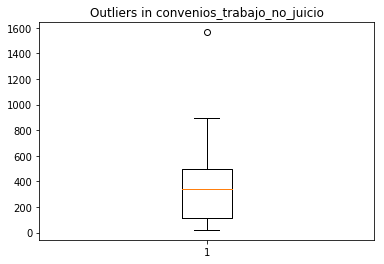

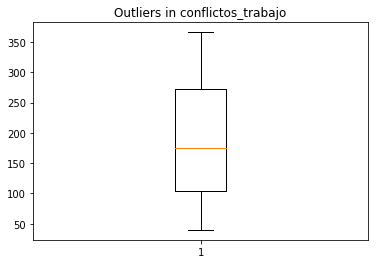

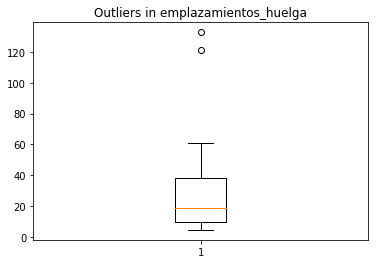

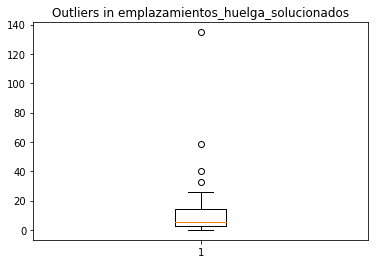

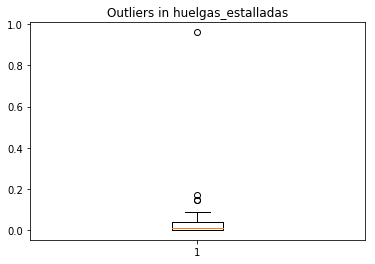

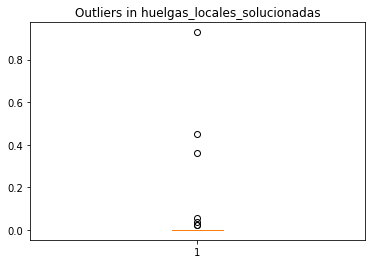

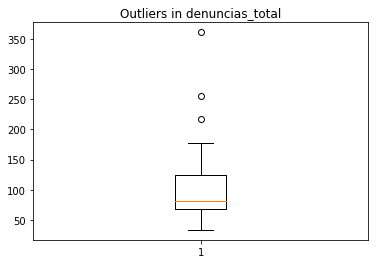

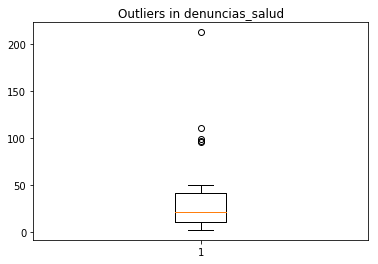

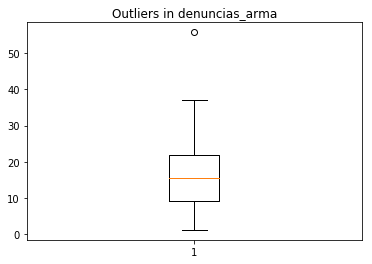

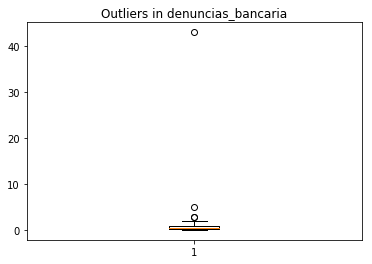

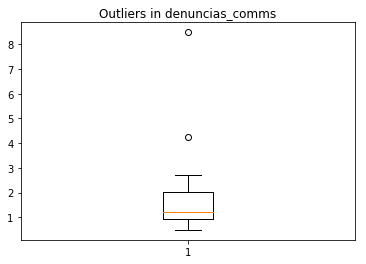

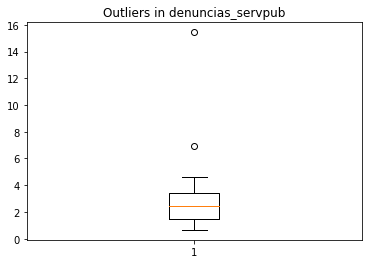

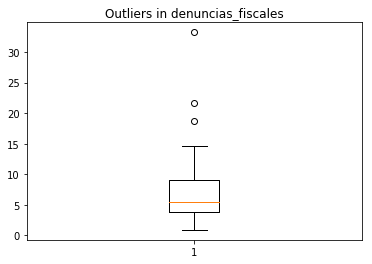

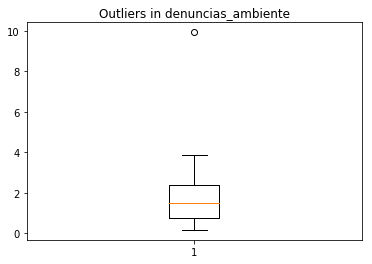

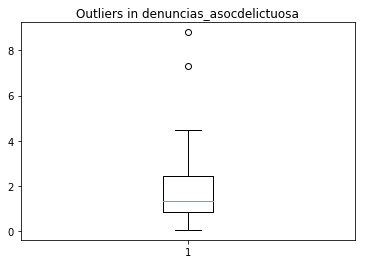

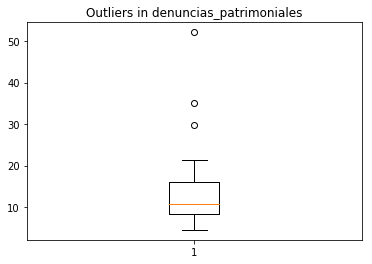

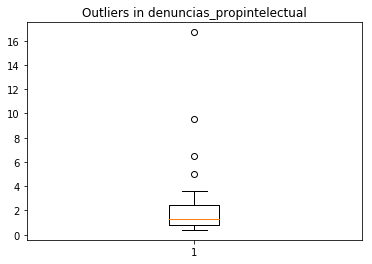

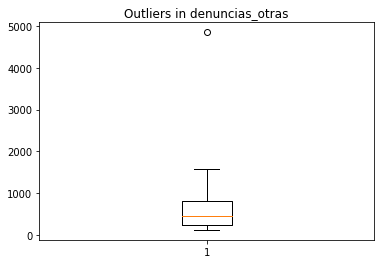

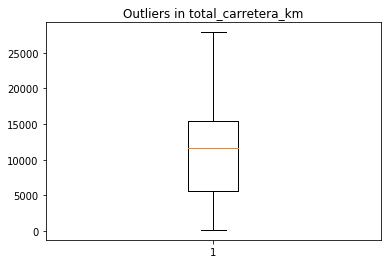

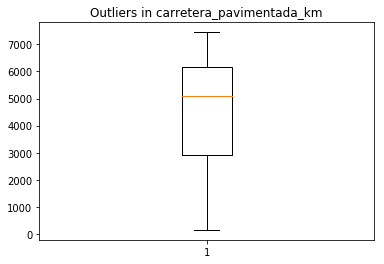

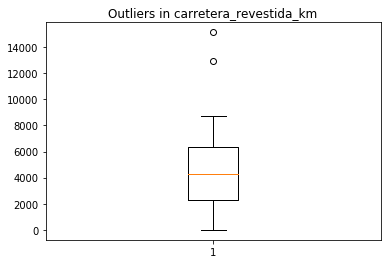

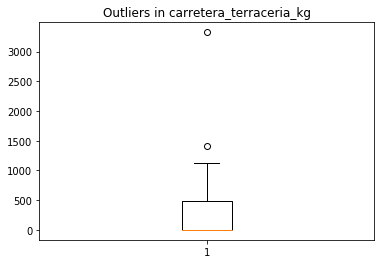

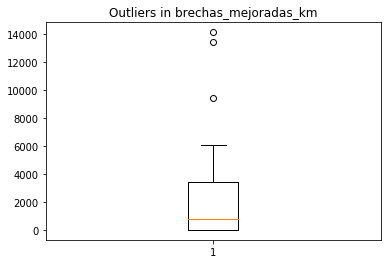

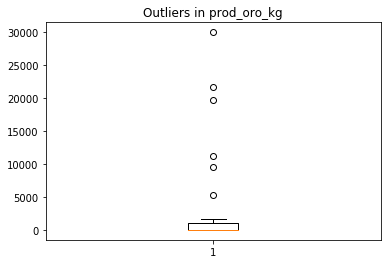

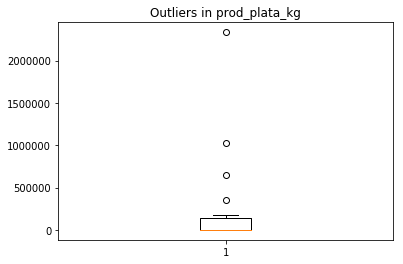

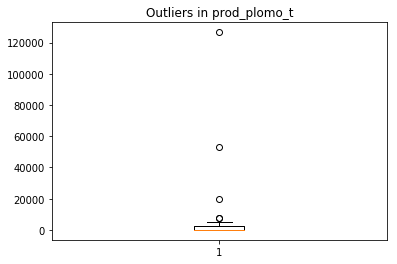

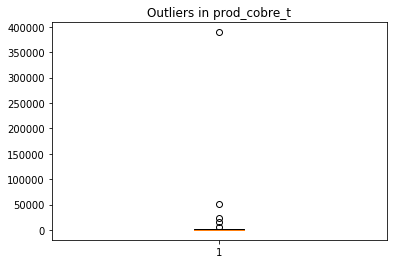

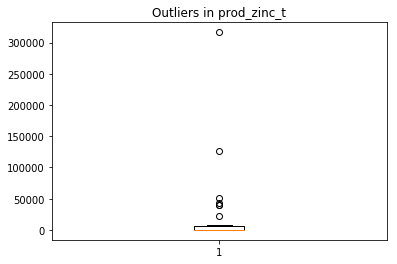

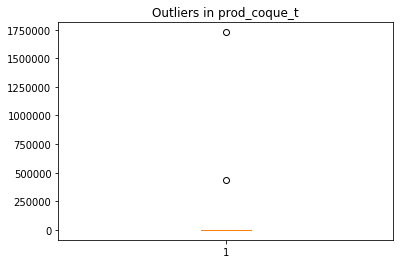

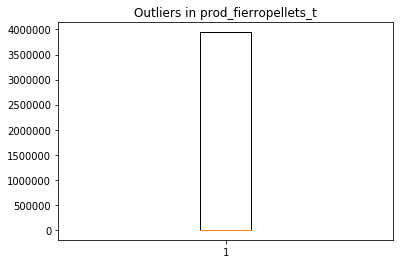

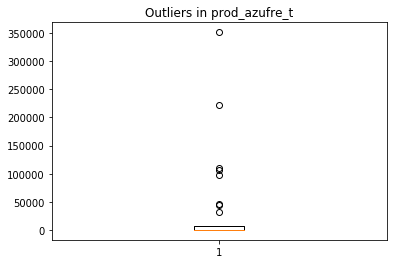

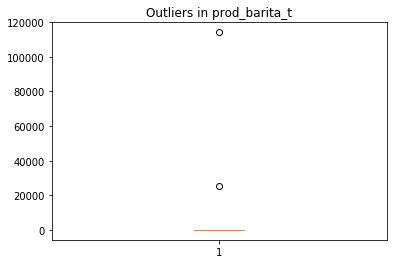

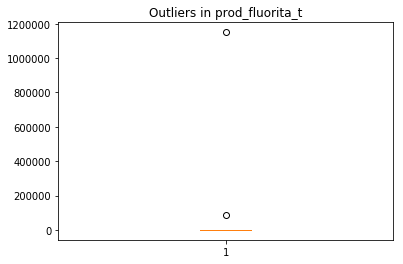

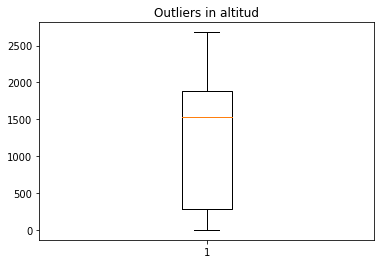

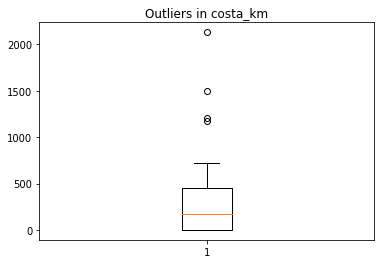

In [8]:
epc.box_plot(index)

Pretty much all variables have some sort of outlier, but it can be reasonably explained in most cases. The metal production variables are susceptible to outliers because a majority of states don't produce metals and therefore drive down the mean -- this also happens with the coast variable. Some of the denuncias variables also have outliers, as well. Typically, you'd want to discretize variables with outliers or turn them into binary variables, but the outliers in this case can be explained by legitimate differences between the states so we'll keep them as is.

#### *Correlation Heatmap* 

We also need to take a look at the correlation heatmap, which should give us a sense of what to expect when take the step of conducting a principal components analysis.

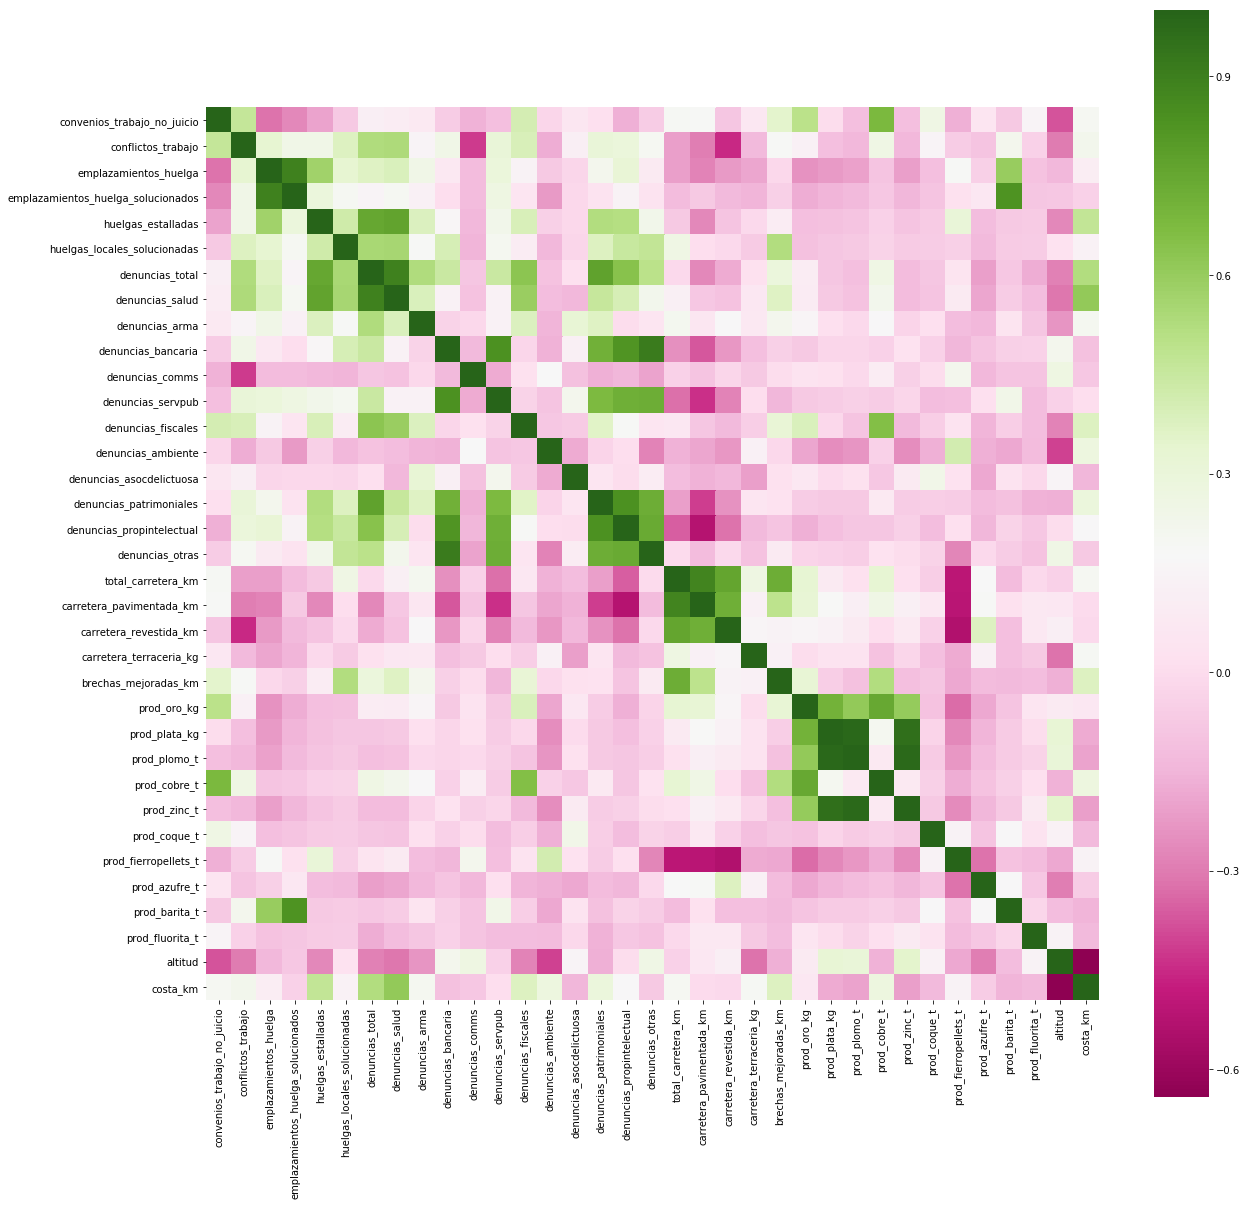

In [9]:
epc.explore_potential_correlations(index)

Generally, the correlation heatmap returns some expected results. There are somewhat weak positive correlations among the labor violence and denuncias variables, which was likely expected. Similarly, there are strong positive correlations between the highway variables, and between the metal production variables (with some exceptions). We'd expect these variables to group together under a principal component analysis, which is the next step in the analysis.

#### *Principal Component Analysis*

The first step in doing this analysis is standardizing all the variables, which is different than normalizing theoretically and functionally. This is necessary since a lot of machine learning algorithms, PCA included, are optimized for standardized variables -- or variables that have the same units across them.

- Theoretically, standardizing transforms the variables onto the unit scale (mean = 0, variance = 1) which measures how variables are distributed from the mean. Functionally, I'm only doing this to implement the PCA algorithm which requires it. I'll keep working_df intact for the next step, which is normalization.
- Theoretically, normalizing transforms the variables into the same units, and standardization is an option in normalizing but not the only one. You can normalize by rank, z-score, and more. Functionally, I'll do that in the next step.

It's important to note that these methods I'll be deploying are largely unsupervised learning methods that try to tease out any similarities between our columns (variables) and rows. 

The purpose of principal component vectors is to group together columns based on how much of the total variance in the dataset they explain. The graph below shows how much variance we maintain if do a principal component analysis to reduce the size of our data from the original 35 columns down to 10.

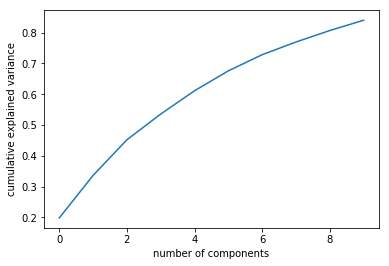

Variance explained for first 10 components in 2012
[19.83188097 33.63787847 45.20451089 53.55212819 61.11173502 67.57467341
 72.81677946 76.93514269 80.66217926 83.99331488]



In [10]:
pca, y_pca = epc.pca(index, 10)
pca_df = epc.pca_df(no_index, pca, y_pca, 10, 'entidad', 'year', '2012')

This principal component analysis successfully reduced our data from 35 columns down to 10 columns, while maintaining 84% of the variance in the original dataset. This is a pretty good result, but in order to fully understand if the principal component vectors are grouping together in a way that makes sense, we need to dive deeper into the reduced dimensionality. 

In the graph below, we take a look at what the values for the first two vectors, which explain 33% of the variance, tell us about possible groupings among the states.

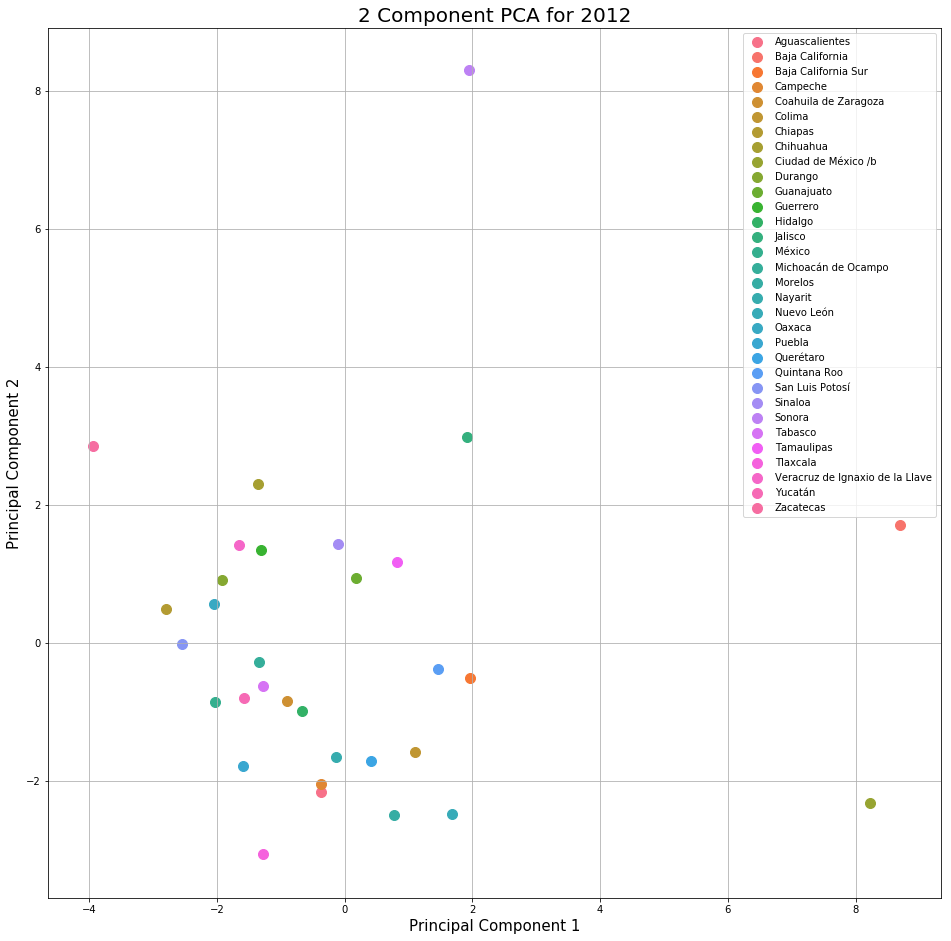

In [11]:
epc.two_dimension_pca_graph(pca_df, 'entidad')

Generally speaking, there is a pretty random distribution among states in the two-vector analysis which is worrisome. It's hard to determine from this graph if there is a natural inclination to the groupings, but it's important to note that we're only taking into account 33% of the total variance.

Instead, we'll shift focus to understanding what variables influenced the component vectors and hope that they grouped together in a way that makes sense.

In [12]:
loading = epc.factor_loadings(pca, no_index, pca_df, 'entidad', 'year')
loading

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
convenios_trabajo_no_juicio,0.010035,0.547202,-0.208295,-0.304005,-0.0387514,-0.692209,0.125922,-0.0225319,0.0719014,0.0191455
conflictos_trabajo,0.608852,0.183587,-0.0528873,-0.116963,0.297313,-0.475877,0.0880744,-0.0862541,0.336478,-0.111828
emplazamientos_huelga,0.570262,-0.225063,-0.151337,0.31609,0.62908,0.192116,-0.0368727,0.140769,0.000461386,-0.0326345
emplazamientos_huelga_solucionados,0.353067,-0.210256,-0.0899939,0.464604,0.734423,0.0426426,0.0531949,0.220473,-0.054886,-0.0722198
huelgas_estalladas,0.727711,0.103113,-0.122553,-0.00500388,0.138184,0.467587,-0.0853981,-0.217336,0.0979776,0.217872
huelgas_locales_solucionadas,0.567133,0.225387,0.0833783,0.317378,-0.100889,0.168434,-0.35056,0.0635344,0.380617,-0.275857
denuncias_total,0.904389,0.354114,-0.00104395,-0.081152,-0.0290005,0.149999,-0.0604938,-0.0815106,-0.0609622,0.118888
denuncias_salud,0.733106,0.430803,-0.195254,-0.0484487,0.113853,0.280119,-0.0968005,-0.062198,0.196249,0.127065
denuncias_arma,0.351531,0.390308,-0.0763886,0.0766662,0.192117,0.124797,-0.1481,-0.459752,-0.499672,0.0463163
denuncias_bancaria,0.62262,-0.157284,0.580386,0.118227,-0.38912,-0.213189,0.012473,0.151307,-0.0223108,-0.0667392


This is a pretty good result. The highlighted values are the variables that had the largest impact on the given vector. 
- Principal Component 1 was mostly influenced by variables that we identified as being positively correlated: work violence, strikes, and denuncias variables. It could be called the crime and work violence variable.
- Principal Component 2 was mostly influenced by highway and metal production variables, so it could be called the presence of industry variable.
- Principal Component 3 was mostly influenced by the remaining metal production variables and a few denuncias variables, so it could be reflective of a different industry metric.

What's more, the results are positive in that they affirm results that we likely expected: in measuring the presence of organized crime, we could plausibly hypothesize that crime would have a larger impact than would highways, and that those could have a larger impact than would metal production. The results from the principal component analysis, though a little weak, track well with how we expected the variables to group and order themselves in terms of importance to the analysis.

#### *Cluster Analysis*

Unlike Principal Component Analysis, clustering groups our states together using unsupervised methods. Using these methods, we hope to ascertain if the states are grouping together in ways that are expected (states that we hypothesize to have higher presence of organized crime would group together with other states that have high presence). 

In this guide, we'll showcase two of the many algorithms that do a clustering analysis

- KMeans -- divides the set of samples into distinct clusters as defined by us (in this case, five). These clusters are defined by the mean of the samples in the cluster, which doesn't have to be an observation. The clusters have equal variance from their respective centroid. Note that this is unsupervised, I'm not creating a test set with the outcome since we don't know it
- Affinity Propagation -- creates clusters by sending messages between pairs of samples until convergence. The messages sent belong to two categories: 1) responsability that a certain sample k should be exemplar of sample i; and 2) availability, or the accumulated evidence that sample i should choose sample k as its exemplar and then consider the values for all other samples that k should be an exemplar. The final choice is made if samples are similar enough to many samples and chosen by many samples to be representative of them.

##### *KMeans*

In [13]:
scores = epc.kmeans_index(no_index, index, 5, ['entidad', 'year', 'score'])
scores

,entidad,year,score
0,Aguascalientes,2012,0
1,Baja California,2012,4
2,Baja California Sur,2012,0
3,Campeche,2012,0
4,Coahuila de Zaragoza,2012,0
5,Colima,2012,0
6,Chiapas,2012,1
7,Chihuahua,2012,1
8,Ciudad de México /b,2012,2
9,Durango,2012,1


It's important to note that these numbers are not a ranking, they are groupings. Once that's taken into account, this is a decent result. As expected, this analysis grouped the following states (which we hypothesize to have a large organized crime presence) together:
- Veracruz, Tamaulipas, Tabasco, Sonora, Sinaloa, San Luis Potosí, Oaxaca, Michoacán, Estado de México, Hidalgo, Guerrero, Guanajuato, Chihuahua, Chiapas

We know, for example, that the majority of those states have significant issues related to organized crime. That said, this analysis is not perfect. Guanajuato, for example, might not need to be grouped in with the rest of these states, and the absence of Nuevo León (which is grouped with another set of states that have issues with organized crime such as Nayarit, Coahuila, and Baja California Sur) is a bit strange. 

This K-Means analysis shows us that a number of the states are grouping together in ways that we'd hope, though it's far from perfect. This indicates that our dataset is decent, though not great.

##### *Affinity Propagation*

In [14]:
epc.affinity_propagation(no_index, index, '2012')


2012
Cluster 1: Aguascalientes, Baja California, Baja California Sur, Campeche, Coahuila de Zaragoza, Colima, Michoacán de Ocampo, Morelos, Nayarit, Puebla, Tlaxcala, Yucatán
Cluster 2: Chihuahua, Ciudad de México /b, Durango, Guanajuato, Guerrero, México, Oaxaca, Sinaloa, Sonora, Zacatecas
Cluster 3: Jalisco, Querétaro, Quintana Roo
Cluster 4: San Luis Potosí
Cluster 5: Chiapas, Hidalgo, Nuevo León, Tabasco, Tamaulipas, Veracruz de Ignaxio de la Llave


/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 5.869e-04
  ConvergenceWarning)


Using affinity propagation returned a different set of results. The groupings are still fairly decent, with states like Nayarit, Michoacán, Coahuila, and the Baja Calfornias grouped together in one group; Guerrero, Sinaloa, and Sonora in another group; Nuevo León and Tamaulipas in yet another. 

That said, the groups generally are a strange mix of states and raise more questions than answers as to whether this dataset is adequate enough to answer the question we want to answer.

Although the data exploration uncovered some issues with our data (principal components that were grouping together somewhat decently, albeit weakly, and clustering that was similarly grouping somewhat decently), we will proceed with the same dataset as the example. Under normal circumstances, the principal component and clustering results would merit a bit of a closer look at the data collection methods and might necessitate new data collection.

## Step 5: Normalizing the Data

### The Rationale

Normalization is a required step if our ultimate goal is to aggregate the variables into a single, composite variable. All the variables must be brought together under the same units in order to make aggregation possible.

### The Methods

There are several methods employed in normalizing data, but we'll only focus on three and deploy one:
- Ranking -- each state is ranked in a variable comparison to other states. This method deals well with outliers and allows you to compare states over time relative to each other.
- Categorical Scale -- each state is assigned a score based on the percentiles of distribution for each variable. Again, this accounts for outliers but it gets rid of a lot information in placing everything in scales.
- Z-Score -- a z-score measures the number of standard deviations an observation is from the mean. This method might not deal with outliers as well, but keeps all the relevant variance information that's lost in the other two methods.


### Normalizing our Dataset

For this particular index, given all the outliers in the dataset, using z-score might not be an adequate strategy. Instead, a method that controls for outliers would be ideal. 

For this guide, we will deploy ranking, given that it gives us a good idea of how states compare to each other and provides more information than would a categorical normalization.

Below are the first five rows of the dataset normalized with ranks.

In [15]:
rank = norm.ranking(index)
rank.head()

,,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,emplazamientos_huelga_solucionados,huelgas_estalladas,huelgas_locales_solucionadas,denuncias_total,denuncias_salud,denuncias_arma,denuncias_bancaria,...,prod_plomo_t,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km
entidad,year,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,2012,18.0,14.0,26.0,23.0,17.0,8.0,19.0,11.0,26.0,7.0,...,10.0,12.0,10.0,3.0,1.0,9.0,3.0,3.0,9.0,18.0
Baja California,2012,30.0,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,3.0,...,10.0,12.0,10.0,3.0,1.0,9.0,3.0,3.0,32.0,2.0
Baja California Sur,2012,16.0,13.0,13.0,16.0,4.0,8.0,5.0,3.0,22.0,29.0,...,10.0,12.0,10.0,3.0,1.0,9.0,3.0,3.0,28.0,1.0
Campeche,2012,8.0,19.0,14.0,28.0,17.0,8.0,24.0,29.0,28.0,30.0,...,10.0,12.0,10.0,3.0,1.0,9.0,3.0,3.0,28.0,10.0
Coahuila de Zaragoza,2012,2.0,6.0,18.0,19.0,17.0,8.0,20.0,21.0,14.0,9.0,...,10.0,12.0,10.0,1.0,11.0,9.0,2.0,2.0,13.0,18.0


## Step 6: Weighting and Aggregating

### The Rationale

Weighting the variables and then aggregating them constitute the last two steps in arriving at a composite index. Weighting variables isn't necessary -- several indices rely on equal weighting schemes in which all variables are given the same weight and then aggregated. However, in thinking about this particular index, it's likely that some variables, such as denuncias, have a greater effect on what we measure than others, such as production of zinc. In this instance, it would be appropriate to weight denuncias more than zinc. 

There are several methods for aggregating, but generally it's important to consider whether there exists a linear relationship between your data before deciding on your method.

### The Methods

Weighting is a fairly subjective practice, and there are several methods available -- including some that don't require any statistical methodology.
- Principal component analysis -- weights are assigned based on the values of the factor loadings for each principal component vector.
- Equal weighting -- all variable are assigned the same weight.
- Expert opinion -- experts are given a fixed set of 'points' to distribute among all the variables, and the average score each variable receives becomes it's weight.

Aggregating, on the other hand, isn't subjective. There are several methods for aggregating values that make assumptions about how variables compensate for each other.
- Addition -- Variables are multiplied by their weights, added together, and then divided by the total number of variables. This method assumes a linear relationship between variables -- they are assumed to be independent of each other.
- Geometric -- Variables are aggregated using a geometric mean. This method does not assume a linear relationship and, while it's still compensatory, it's not as compensatory as addition.

### Weighting and Aggregating our Data

#### *Weighting*

Since we can't recreate expert opinion in this guide, and do to the simplicity of equal weighting, we will deploy principal component analysis weights in this guide. Generally speaking, assigning weights using this method requires multiple steps.

The first step is determining what correlations exist among the normalized variables, which would be a measure of how robust a PCA weighting model could be. The correlation heatmap is below.

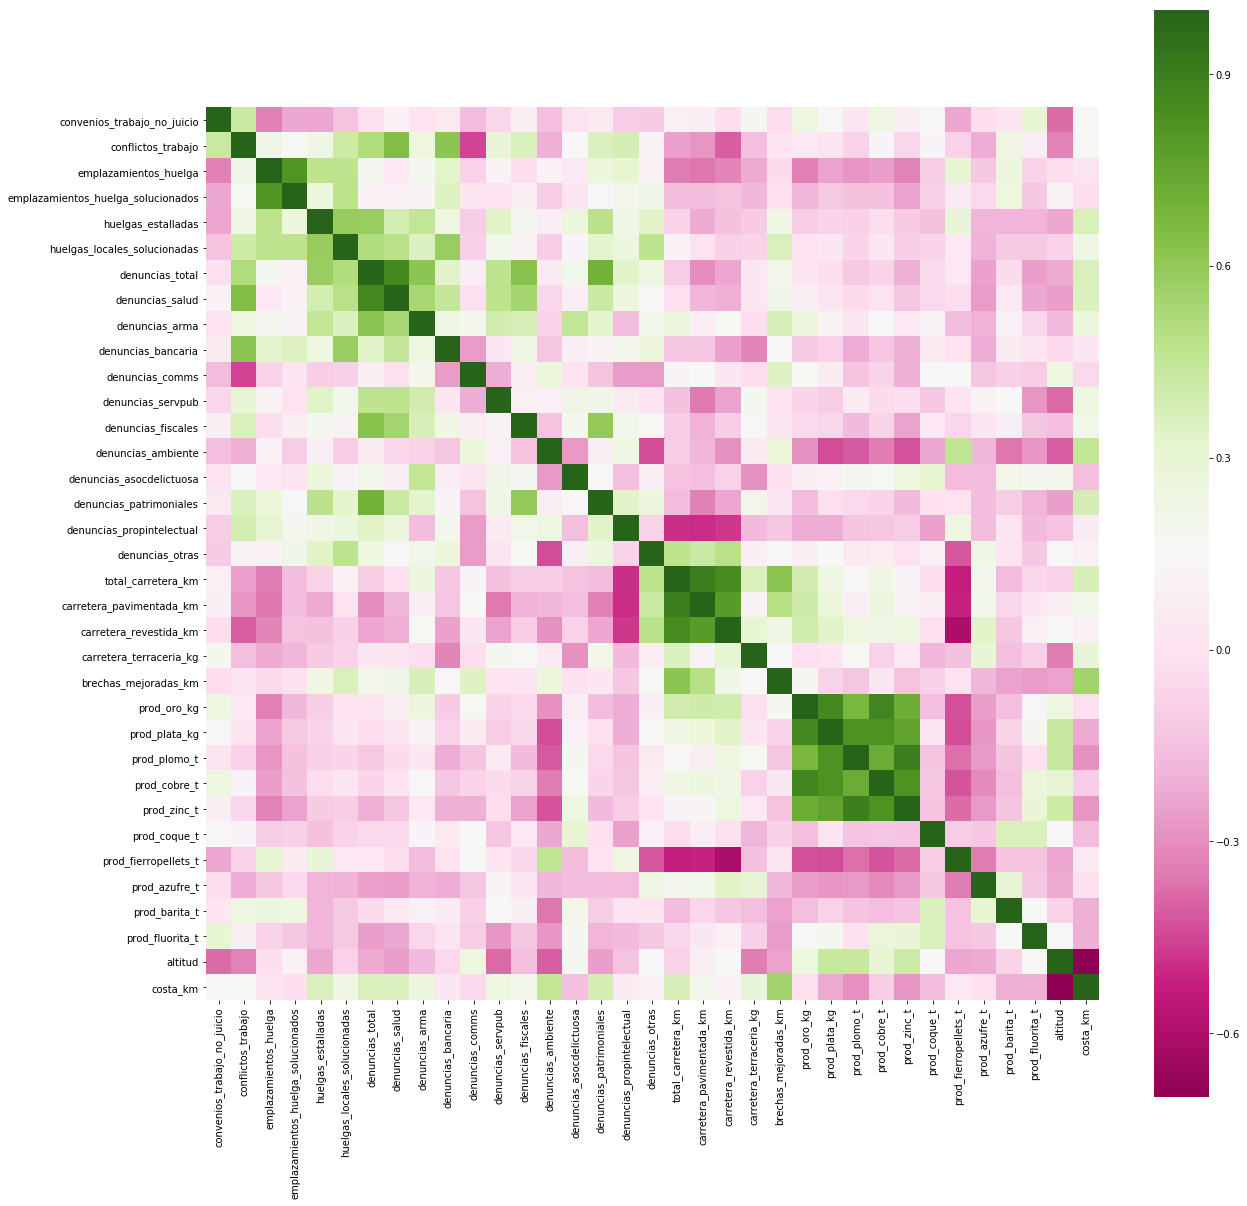

In [16]:
epc.explore_potential_correlations(rank)

Generally speaking, our ranked dataset has similar correlations as the original one. There are weak positive correlations among the denuncias variables, and stronger positive correlations among the highway and metal production variables. This seems to be a decent enough dataset to do PCA analysis on.

The next step is to identify which principal components represent the data. For this determination, there are three basic rules: the vectors must have eigenvalues greater than 1, each individual vector must capture at least 10% of the total variance, and the cumulative variance captured must be greater than 60%.

In [18]:
from sklearn import preprocessing, decomposition
#std_array = preprocessing.fit_transform(rank)
pc1 = decomposition.PCA(n_components = 5)
y_pca1 = pc1.fit_transform(rank)
no_idxrank = rank.reset_index()

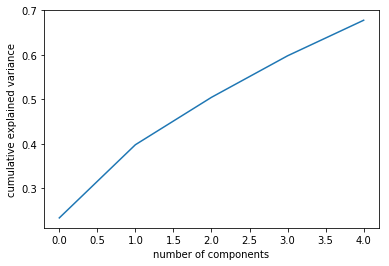

Variance explained for first 5 components in 2012
[23.35707317 39.79603196 50.44621559 59.77376876 67.76198674]



In [19]:
pca_df1 = wts.pca_df(no_idxrank, pc1, y_pca1, 5, 'entidad', 'year', '2012')

As is evident in the above graph, the first five vectors fit two out of our three requirements (we've yet to figure out how to calculate eigenvalues). But each of the first five vectors accounts for close to 10% of the total variance, with the exception of vectors 4 and 5, which are 9% and 8% respectively, which is close enought. And, cumulatively, the first five vectors account for more than 60% of the total variance.

The next step in this weighting model is to determine the factor loadings to see how variables group together, and to get a sense of how much they contribute to the variance. From there, we will begin apportioning weights.

In [20]:
factor_loads = wts.factor_loadings(pc1, rank, pca_df1, 'entidad', 'year')
factor_loads

,PC1,PC2,PC3,PC4,PC5
convenios_trabajo_no_juicio,-0.298469,-1.692168,2.928614,6.232285,1.137263
conflictos_trabajo,-6.823838,-1.629418,-0.671295,4.385177,2.109572
emplazamientos_huelga,-4.509583,2.162796,-4.135035,-4.649302,3.080664
emplazamientos_huelga_solucionados,-3.177553,0.639857,-5.279091,-3.986881,3.210066
huelgas_estalladas,-3.064238,-1.229880,-0.504395,-1.923346,0.186379
huelgas_locales_solucionadas,-0.965637,-0.658403,-0.558220,-0.495625,0.529042
denuncias_total,-7.554494,-3.831394,1.028896,-1.266132,-2.081148
denuncias_salud,-6.815914,-4.078935,1.221313,0.573802,-0.990965
denuncias_arma,-3.863826,-5.930062,0.017473,-2.417949,-3.131515
denuncias_bancaria,-4.756358,-1.548923,-3.155607,0.782308,2.918256


Generally speaking, PC1 seems to group together the highway variables, PC2 captures some denuncias variables, as those PC3. PC4 is captured mostly by metal production variables.

For each component vector, you then take the square of all of the loadings and sum them. Then divide each loading by the total sum to get each loading as a percent of total sum of squares explained for that particular vector.

In [21]:
ss_df, perc_list = wts.ss_loadings(factor_loads)
ss_df

,PC1,PC2,PC3,PC4,PC5
convenios_trabajo_no_juicio,1.909171e-04,8.719236e-03,0.040312,0.208445,8.104713e-03
conflictos_trabajo,9.979404e-02,8.084556e-03,0.002118,0.103198,2.788718e-02
emplazamientos_huelga,4.358328e-02,1.424368e-02,0.080365,0.116004,5.947090e-02
emplazamientos_huelga_solucionados,2.163879e-02,1.246686e-03,0.130987,0.085303,6.457190e-02
huelgas_estalladas,2.012298e-02,4.605923e-03,0.001196,0.019852,2.176759e-04
huelgas_locales_solucionadas,1.998365e-03,1.320001e-03,0.001465,0.001318,1.753863e-03
denuncias_total,1.223089e-01,4.469974e-02,0.004976,0.008603,2.714073e-02
denuncias_salud,9.956243e-02,5.066231e-02,0.007011,0.001767,6.153643e-03
denuncias_arma,3.199502e-02,1.070803e-01,0.000001,0.031376,6.145042e-02
denuncias_bancaria,4.848377e-02,7.305514e-03,0.046803,0.003284,5.336572e-02


Then for each row in the sum of squares loading, you only keep the maximum value. You sum those for each component vector and multiply that value by the percent of variance of total sum squares that vector explains.

You then used that number to divide the multiplication of each max value in a component by the percent that vector explains and that gets you your weight for that variable -- which in this case is the array below.

In [22]:
wt = wts.calculate_weights(ss_df, perc_list)
wt

array([3.13073023e-01, 1.54997713e-01, 1.74231466e-01, 2.25205775e-01,
       4.06964588e-02, 4.04146767e-03, 2.47355880e-01, 2.01353772e-01,
       1.63806636e-01, 2.02841711e-01, 2.45230941e-01, 9.74648125e-02,
       1.17496819e-01, 3.06800852e-01, 7.48147892e-01, 1.71238658e-01,
       1.20352131e-01, 1.66998398e-01, 2.58965260e-01, 1.73093451e-01,
       1.77864051e-01, 3.44897851e-02, 9.33251704e-02, 1.03923985e-02,
       2.59607799e-02, 1.76784106e-02, 1.02948958e-02, 8.70401620e-03,
       1.87734538e-04, 4.88798045e-02, 5.18347214e-03, 8.92907779e-05,
       1.42774792e-04, 3.39153221e-01, 9.42610755e-02])

Finally, you multiply the weights by the original values to get your weighted values -- as below.

In [23]:
w_df = wts.apply_weights(rank, wt)
w_df

,,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,emplazamientos_huelga_solucionados,huelgas_estalladas,huelgas_locales_solucionadas,denuncias_total,denuncias_salud,denuncias_arma,denuncias_bancaria,...,prod_plomo_t,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km
entidad,year,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,2012,5.635314,2.169968,4.530018,5.179733,0.691840,0.032332,4.699762,2.214891,4.258973,1.419892,...,0.176784,0.123539,0.087040,0.000563,0.048880,0.046651,0.000268,0.000428,3.052379,1.696699
Baja California,2012,9.392191,0.774989,0.348463,0.450412,0.040696,0.008083,0.247356,0.201354,0.327613,0.608525,...,0.176784,0.123539,0.087040,0.000563,0.048880,0.046651,0.000268,0.000428,10.852903,0.188522
Baja California Sur,2012,5.009168,2.014970,2.265009,3.603292,0.162786,0.032332,1.236779,0.604061,3.603746,5.882410,...,0.176784,0.123539,0.087040,0.000563,0.048880,0.046651,0.000268,0.000428,9.496290,0.094261
Campeche,2012,2.504584,2.944957,2.439241,6.305762,0.691840,0.032332,5.936541,5.839259,4.586586,6.085251,...,0.176784,0.123539,0.087040,0.000563,0.048880,0.046651,0.000268,0.000428,9.496290,0.942611
Coahuila de Zaragoza,2012,0.626146,0.929986,3.136166,4.278910,0.691840,0.032332,4.947118,4.228429,2.293293,1.825575,...,0.176784,0.123539,0.087040,0.000188,0.537678,0.046651,0.000179,0.000286,4.408992,1.696699
Colima,2012,5.322241,3.099954,1.045389,2.252058,0.122089,0.032332,2.473559,3.624368,0.491420,3.245467,...,0.176784,0.123539,0.087040,0.000563,0.048880,0.046651,0.000268,0.000428,7.800524,1.602438
Chiapas,2012,7.513753,4.959927,5.575407,6.981379,0.691840,0.032332,6.925965,5.235198,4.750392,4.665359,...,0.176784,0.123539,0.087040,0.000563,0.635437,0.010367,0.000268,0.000428,7.122218,1.319655
Chihuahua,2012,3.756876,1.704975,5.401175,6.756173,0.691840,0.032332,2.720915,1.812184,1.474260,4.056834,...,0.035357,0.041180,0.017408,0.000563,0.635437,0.046651,0.000268,0.000428,4.748145,1.696699
Ciudad de México /b,2012,5.948387,1.084984,1.742315,2.477264,0.081393,0.012124,0.494712,1.409476,3.112326,0.202842,...,0.070714,0.061769,0.043520,0.000563,0.635437,0.046651,0.000268,0.000428,1.017460,1.696699


#### *Aggregating*

Due to the fact that our variables are likely compensatory -- that is that they're not entirely independent from each other, we will deploy the geometric mean aggregation method to obtain our final index score. 

In [24]:
gmean = wts.geometric_aggregation(w_df, 'float')
gmean

entidad                          year
Aguascalientes                   2012    5
Baja California                  2012    1
Baja California Sur              2012    3
Campeche                         2012    5
Coahuila de Zaragoza             2012    4
Colima                           2012    3
Chiapas                          2012    5
Chihuahua                        2012    3
Ciudad de México /b              2012    1
Durango                          2012    4
Guanajuato                       2012    3
Guerrero                         2012    3
Hidalgo                          2012    4
Jalisco                          2012    2
México                           2012    4
Michoacán de Ocampo              2012    4
Morelos                          2012    3
Nayarit                          2012    4
Nuevo León                       2012    3
Oaxaca                           2012    3
Puebla                           2012    5
Querétaro                        2012    4
Quintana Roo    

As you can see, the weighting and aggregating in this case did not result in a sound index. States like Sinaloa and Nuevo León, which we know to have a significant presence of organized crime, scored a three on this index range. While states like Campeche and Aguascalientes scored a five. This is more than likely due to the underying data being not indicative of what we wanted to measure ultimately. 